## Credit Card Fraud Detection with Synthetic Financial Datasets


Data collected from https://www.kaggle.com/ealaxi/paysim1/code

Article References: 1: Google article from Jayanta Kumar Pal - https://jayant017.medium.com/hyperparameter-tuning-in-xgboost-using-randomizedsearchcv-88fcb5b58a73

                    2 : Google article from Prashant Tyagi - https://www.sqlservercentral.com/articles/model-selection-and-performance-boosting-with-k-fold-cross-validation-and-xgboost
                    
                    3 : Google article  Niklas Donges - https://builtin.com/data-science/random-forest-algorithm

In [2]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime
from library.sb_utils import save_file
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import accuracy_score,log_loss
from matplotlib import pyplot

In [3]:
df = pd.read_csv('C:\\Projects\\SpringBoard\\Capstone 2_Credit Card Fraud\\creditcard_preprocessing.csv')

In [4]:
df.head(2)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,transactionHour,transactionPeriod
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1,Mid
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1,Mid


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 13 columns):
 #   Column             Dtype  
---  ------             -----  
 0   step               int64  
 1   type               object 
 2   amount             float64
 3   nameOrig           object 
 4   oldbalanceOrg      float64
 5   newbalanceOrig     float64
 6   nameDest           object 
 7   oldbalanceDest     float64
 8   newbalanceDest     float64
 9   isFraud            int64  
 10  isFlaggedFraud     int64  
 11  transactionHour    int64  
 12  transactionPeriod  object 
dtypes: float64(5), int64(4), object(4)
memory usage: 631.1+ MB


###### Origin Error Balance in Amount

  - The below cell explains the error in origin account balance amount after transaction (outgoing transaction)

      - Error = (New Balance + Transaction Amount) - Old Balance
      - prove that the old and new balance in origin account are zero

In [13]:
df["errorBalanceOrig"]= df['newbalanceOrig'] + df['amount'] - df['oldbalanceOrg']

In [14]:
# flag to indicate whether both oldbalanceOrg and newbalanceOrig in origin account are zero
df['zeroBalanceOrig'] = df['oldbalanceOrg'] + df['newbalanceOrig']
df['zeroBalanceOrig'] = df['zeroBalanceOrig'].apply(lambda x: 1 if x == 0 else 0)

######  Destination Error Balance in Amount

  - The below cell explains the error in destination account balance amount after transaction (outgoing transaction)

      - Error = Error = (Old Balance + Transaction Amount) - New Balance
      - prove that the old and new balance in destination account are zero

In [15]:
df['errorBalanceDest'] = df['oldbalanceDest'] + df['amount'] - df['newbalanceDest']

In [16]:
# flag to indicate whether both old and new balance in destination account are zero
df['zeroBalanceDest'] = df['oldbalanceDest'] + df['newbalanceDest']
df['zeroBalanceDest'] = df['zeroBalanceDest'].apply(lambda x: 1 if x == 0 else 0)

In [17]:
print(df.loc[df.type == 'CASH_OUT'].nameDest.str.contains('M').any())
print(df.loc[df.type == 'CASH_IN'].nameOrig.str.contains('M').any())
print((df.loc[df.nameDest.str.contains('M')].type != 'PAYMENT').any())
print(df.loc[df.type == 'TRANSFER'].nameDest.str.contains('M').any())

False
False
False
False


Observations:

Merchant accounts are not included in the fraudulent Transactions and it is only identified in 'PAYMENT' type transactions.

In [18]:
# subsetting fraudulent transactions
is_fraud = df[df['isFraud'] == 1].drop(columns=['isFlaggedFraud'])

# subsetting non-fraudulent transactions
not_fraud = df[(df['isFraud'] == 0) & (df['type'].isin(['CASH_OUT','TRANSFER']))].drop(columns=['isFlaggedFraud'])
# creating a new dataframe from sub-sampled data
df_new = pd.concat([is_fraud, not_fraud], axis=0)
df_new.head()


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,transactionHour,transactionPeriod,errorBalanceOrig,zeroBalanceOrig,errorBalanceDest,zeroBalanceDest
2,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,1,Mid,0.0,0,181.0,1
3,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,1,Mid,0.0,0,21363.0,0
251,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,1,Mid,0.0,0,2806.0,1
252,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,1,Mid,0.0,0,29008.0,0
680,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,1,Mid,0.0,0,20128.0,1


In [19]:
df_new.iloc[:,1].unique()

array(['TRANSFER', 'CASH_OUT'], dtype=object)


   ### Train/Test Split

####  Split the data into test and train subsamples

 - Before the model development, split the data into train and test samples.

In [20]:
X = df_new.drop(columns=['isFraud', "nameOrig", "nameDest"])
y = df_new['isFraud']


In [21]:
X.type.replace(to_replace=dict(TRANSFER=1, CASH_OUT=0), inplace=True)

In [22]:
X.transactionPeriod.replace(to_replace=dict(Mid=0, Peak=1,Safe=2 ), inplace=True)

 leave out some data (for testing) and train the model on the rest
  - Split the data into a training and test (hold-out) set


In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2216327, 13), (554082, 13), (2216327,), (554082,))

In [24]:
y_test

2650057    0
4800233    0
3770686    0
5115227    0
6052360    0
          ..
2553954    0
836797     0
1142115    0
1278848    0
2860445    0
Name: isFraud, Length: 554082, dtype: int64

In [25]:
#Check the `dtypes` attribute of `X_train` to verify all features are numeric
X_train.dtypes

step                   int64
type                   int64
amount               float64
oldbalanceOrg        float64
newbalanceOrig       float64
oldbalanceDest       float64
newbalanceDest       float64
transactionHour        int64
transactionPeriod      int64
errorBalanceOrig     float64
zeroBalanceOrig        int64
errorBalanceDest     float64
zeroBalanceDest        int64
dtype: object

In [26]:
#Repeat this check for the test split in `X_test`
X_test.dtypes

step                   int64
type                   int64
amount               float64
oldbalanceOrg        float64
newbalanceOrig       float64
oldbalanceDest       float64
newbalanceDest       float64
transactionHour        int64
transactionPeriod      int64
errorBalanceOrig     float64
zeroBalanceOrig        int64
errorBalanceDest     float64
zeroBalanceDest        int64
dtype: object

## Modelling 

  ###  Model 1 : Random Forest Classifier
  
  Random Forest builds with ensemble of multiple decision trees and  usually trained with the “bagging” method. Here we use  random forest in classification problem. 
   - Bagging is called the Bootstrap Aggregation.
   - The base learner is Decision Tree
   - Each tree build from Bootstrap sample.
   - It is used to investigate the importance of the feature with a large data set.
   - Take the raw sampling and feature sampling to the decision tree to train the data.
      - Training done in parellel.
   - Using unweighted voting for final prediction
   - Easier to tune and harder to overfit.
   

Normally scaling is not required for Random Forest classifier as it is Decision Tree based algorithm. But In our first case I am trying to predict the value with scaled data.

In [27]:
# build scaler based on training data and apply it to test data to then also scale the test data
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [28]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=300, random_state = 1,n_jobs=-1)
model_res = clf.fit(X_train_scaled, y_train)
y_pred = model_res.predict(X_test_scaled)
ac = accuracy_score(y_test, y_pred)

f1 = f1_score(y_test, y_pred, average='weighted')
cm = confusion_matrix(y_test, y_pred)

print('Random Forest: Accuracy=%.3f' % (ac))

print('Random Forest: f1-score=%.3f' % (f1))

Random Forest: Accuracy=1.000
Random Forest: f1-score=1.000


In [29]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

rf_classifier=RandomForestClassifier(n_estimators=10).fit(X_train,y_train)
prediction=rf_classifier.predict(X_test)
print(confusion_matrix(y_test,prediction))
print(accuracy_score(y_test,prediction))
print(classification_report(y_test,prediction))

[[552452      2]
 [    12   1616]]
0.9999747329817609
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552454
           1       1.00      0.99      1.00      1628

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082



In [30]:
from sklearn.metrics import confusion_matrix
TP, FP, FN, TN = confusion_matrix(y_test, prediction).ravel()
c_matrix = pd.DataFrame({'Predicted = Fraud': [TP, FP],
                                 'Predicted = Not Fraud': [FN, TN]
                                }, index=['Fraud', 'Not Fraud'])
c_matrix

,Predicted = Fraud,Predicted = Not Fraud
Fraud,552452,12
Not Fraud,2,1616


Here we have to reduce the type I error(False Positive) as  12 fraud values are predicted not fraud. So we have to find the precision score. 

 Accuracy Score is not a good metric for imbalanced data. So, hyperparameter tuning, F-Beta store or Roc-AUC score will be a better value.
 
   ##### Calculate the ROC for the model as well

In [31]:
# roc curve for models

y_pred_prob = rf_classifier.predict_proba(X_test)

fpr1, tpr1, thresh1 = roc_curve(y_test, y_pred_prob[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, y_pred_prob[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [32]:
# auc scores
auc_score1 = roc_auc_score(y_test, y_pred_prob[:,1])
auc_score2 = roc_auc_score(y_test, y_pred_prob[:,1])

print(auc_score1, auc_score2)

0.9969274004682381 0.9969274004682381


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


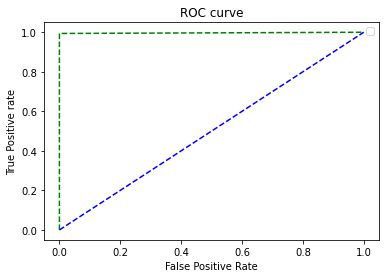

In [33]:
plt.plot(fpr2, tpr2, linestyle='--',color='green')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label99
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [ ]:
# roc curve for models

y_pred_prob = rf_classifier.predict_proba(X_test)

fpr1, tpr1, thresh1 = roc_curve(y_test, y_pred_prob[:,1], pos_label=1)
fpr2, tpr2, thresh2 = roc_curve(y_test, y_pred_prob[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [ ]:
# auc scores
auc_score1 = roc_auc_score(y_test, y_pred_prob[:,1])
auc_score2 = roc_auc_score(y_test, y_pred_prob[:,1])

print(auc_score1, auc_score2)

In [34]:
from sklearn.metrics import recall_score, precision_score
print(f"recall_score:  {recall_score(y_test, prediction)}")
print(f"precision_score:  {precision_score(y_test, prediction)}")
print(f"F1 score:  {f1_score(y_test, prediction, average='weighted')}")

recall_score:  0.9926289926289926
precision_score:  0.9987639060568603
F1 score:  0.999974694175862


Text(0.5, 1.0, 'RandomForest Precision / Recall plot')

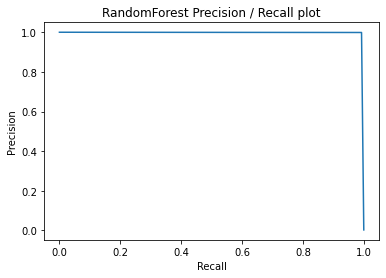

In [82]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, prediction)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('RandomForest Precision / Recall plot')

#### Hyperparameter tuning

 
   ####   Manual Hyperparameter Tuning
 
 - Increasing the predictive power
    - n_estimators : number of trees the algorithm builds before taking the maximum voting or taking the averages of predictions.
    - max_features : maximum number of features random forest considers to split a node.
 - Increasing the model's speed
    - n_jobs : The n_jobs hyperparameter tells the engine how many processors it is allowed to use. If it has a value of one, it can only use one processor. A value of “-1” means that there is no limit.
    - random_state : hyperparameter makes the model’s output replicable
    - The minimum number of samples required to be at a leaf node

In [27]:
### Manual Hyperparameter Tuning
model=RandomForestClassifier(n_estimators=300,criterion='entropy',
                             max_features='sqrt',min_samples_leaf=10,random_state=100).fit(X_train_scaled,y_train)
predictions=model.predict(X_test_scaled)
print(confusion_matrix(y_test,predictions))
print(accuracy_score(y_test,predictions))
print(classification_report(y_test,predictions))

[[552452      2]
 [    12   1616]]
0.9999747329817609
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552454
           1       1.00      0.99      1.00      1628

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082



**<font color='Red'> RF Observation: </font>**

 - <font color='blue'>  Here it is clear that the precision score gives us 99.87%.  ROC curve - 99.72% and F1 score gives us 99.99%. 
  
  
 - <font color='blue'> Here we found type I error(False Positive) with 12 fraud values which predicted not fraud. So we found the precision score. 


 - <font color='blue'>  Accuracy Score is not a good metric for imbalanced data. So, here we performed hyperparameter tuning, F-Beta store, ROC-AUC score, and precision score to get  better performance.
  
  
 - <font color='blue'> As we got good accuracy with Manual method, RandomizedSearchCV / GridsearchCV is not performed.

###  Model 2: XgBoost Classifier

XGBoost is an implementation of gradient boosted decision trees designed for speed and performance that is dominative competitive machine learning.
Gradient boosting refers to a class of ensemble machine learning algorithms that can be used for classification or regression predictive modeling problems. Ensembles are constructed from decision tree models. Trees are added one at a time to the ensemble and fit to correct the prediction errors made by prior models.

The XGBoost model for classification is called XGBClassifier. We can create and and fit it to our training dataset. Models are fit using the model.fit() function.

Parameters for training the model can be passed to the model in the constructor.

### Hyperparameter Optimization For XgBoost using RandomizedSearchCV

We will use RandomizedSearchCV for hyperparameter optimization. It basically works with various parameters internally and finds out the best parameters that XGBoost algorithm can work better with.

Create a dictionary of some parameters to be trained. Here the keys are basically the parameters and the values are a list of values of the parameters to be trained upon. So the GridSearchCV will test each value and find out the particular value which gives the highest accuracy.

Accuracy Score is not a good metric for imbalanced data. So, hyperparameter tuning, F-Beta store or Roc-AUC, Precision Score are  good to ge a better value.

In [35]:

# hyperparameter tuning with XGBoost
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV



# creating a KFold object 
folds = 3

# specify range of hyperparameters
param_grid = {'learning_rate': [0.2, 0.6], 
             'subsample': [0.3, 0.6, 0.9]}          


# specify model
xgb_model = XGBClassifier(max_depth=2, n_estimators=200)

# set up GridSearchCV()
XgB_model_cv = GridSearchCV(estimator = xgb_model, 
                        param_grid = param_grid, 
                        scoring= 'roc_auc', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True)      

# fit the model
XgB_model_cv.fit(X_train, y_train)       

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
C:\Users\archu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:53:45] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\archu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:55:37] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\archu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:57:34] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\archu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[12:59:31] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\archu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:01:50] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\archu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:04:25] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\archu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:06:52] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\archu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:09:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\archu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:11:58] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\archu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:14:30] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\archu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:16:40] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\archu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:18:49] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\archu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:20:53] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\archu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:23:16] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\archu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:25:36] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\archu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:27:56] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\archu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:30:28] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


C:\Users\archu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:32:59] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed: 41.6min finished
C:\Users\archu\anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:35:21] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=2, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=200, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=No

In [36]:
XgB_model_cv.best_params_

{'learning_rate': 0.2, 'subsample': 0.6}

In [37]:
# Applying the hyperparameters

params = {'learning_rate': 0.2,
          'max_depth': 2, 
          'n_estimators':200,
          'subsample':0.6,
         'objective':'binary:logistic'}

# fit model on training data
XgB_df_model = XGBClassifier(params = params)
XgB_df_model.fit(X_train, y_train)

[13:38:35] WARNING: ..\src\learner.cc:576: 
Parameters: { "params" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[13:38:38] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1,
              params={'learning_rate': 0.2, 'max_depth': 2, 'n_estimators': 200,
                      'objective': 'binary:logistic', 'subsample': 0.6},
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

####  Predictions on the test set

We can make predictions using the fit model on the test dataset. Also, evaluate the performance of the predictions by comparing them to the expected values.

In [40]:
# Predictions on the test set
XgB_test_pred = XgB_df_model.predict(X_test)

In [41]:
from sklearn.metrics import confusion_matrix
TP, FP, FN, TN = confusion_matrix(y_test, XgB_test_pred).ravel()
c_matrix = pd.DataFrame({'Predicted = Fraud': [TP, FP],
                                 'Predicted = Not Fraud': [FN, TN]
                                }, index=['Fraud', 'Not Fraud'])
c_matrix

,Predicted = Fraud,Predicted = Not Fraud
Fraud,552454,10
Not Fraud,0,1618


Here we have to reduce the type I error(False Positive) as 10 fraud values are predicted not fraud. So we have to find the precision score.


   #### Calculate the ROC for the model as well

In [42]:
XgB_pred_prob = XgB_df_model.predict_proba(X_test)

fpr_XgB1, tpr_XgB1, XgB_thresh1 = roc_curve(y_test, XgB_test_pred, pos_label=1)
fpr_XgB2, tpr_XgB2, XgB_thresh2 = roc_curve(y_test, XgB_test_pred, pos_label=1)
# roc curve for tpr = fpr 
XgB_probs = [0 for i in range(len(y_test))]
p_fpr_XgB, p_tpr_XgB, _ = roc_curve(y_test, XgB_probs, pos_label=1)

In [43]:
# auc scores
auc_score_XGB1 = roc_auc_score(y_test, XgB_pred_prob[:,1])
auc_score_XgB2 = roc_auc_score(y_test, XgB_pred_prob[:,1])

print(auc_score_XGB1, auc_score_XgB2)

0.9983271306682395 0.9983271306682395


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


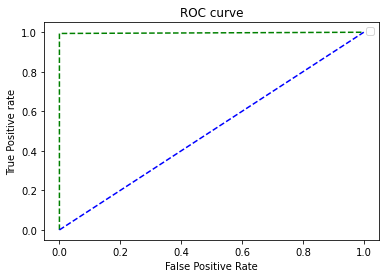

In [44]:
plt.plot(fpr_XgB2, tpr_XgB2, linestyle='--',color='green')
plt.plot(p_fpr_XgB, p_tpr_XgB, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [45]:
from sklearn.metrics import recall_score, precision_score
print(f"recall_score:  {recall_score(y_test, XgB_test_pred)}")
print(f"precision_score:  {precision_score(y_test, XgB_test_pred)}")
print(f"F1 score:  {f1_score(y_test, XgB_test_pred, average='weighted')}")

recall_score:  0.9938574938574939
precision_score:  1.0
F1 score:  0.9999819244113302


Text(0.5, 1.0, 'XgBoost Precision / Recall plot')

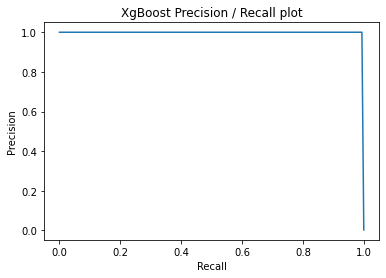

In [83]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, XgB_test_pred)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('XgBoost Precision / Recall plot')

In [46]:
# classification_report
print(classification_report(y_test, XgB_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552454
           1       1.00      0.99      1.00      1628

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082



  
  **<font color='Red'> XgBoost Observation: </font>**

 - <font color='blue'>  Here it is clear that the precision score gives us  100%. ROC curve - 99.83% and F1 score gives us 99.99%
  
  
 - <font color='blue'> Here we found type I error(False Positive) with 10 fraud values which predicted not fraud. So we found the precision score. 


 - <font color='blue'>  Accuracy Score is not a good metric for imbalanced data. So, here we performed hyperparameter tuning, F-Beta store, ROC-AUC score, and precision score to get  better performance.
  
  
 - <font color='blue'> Here we have performed GridsearchCV for the best accuracy.

### Model 3: Logistic Regression

There are different ways of making classifications. 
  - Train on the training set, and test for accuracy on the testing set
  - Logistic regression is mainly used to solve Binary classification problem and when the dependent variable is catogorical.
  - This binary logistic classification problem should be linearly Seperable.
  


#### Tuning the Model

   Now perform model tuning and selecting the regularization parameter 'C' in classification.

For each C:

  - Create a logistic regression model with that value of C
   - Pick the C with the accuracy_score

In [47]:
#the grid of parameters to search over
Cs = [0.01, 0.1, 1]


for C in Cs:
    logreg = LogisticRegression(C=C)
    
#Fit the model on the train set
logreg_model = logreg.fit(X_train, y_train)

# Prediction on the test set
y_test_pred = logreg_model.predict(X_test)

In [48]:
from sklearn.metrics import confusion_matrix
TP, FP, FN, TN = confusion_matrix(y_test, y_test_pred).ravel()
c_matrix = pd.DataFrame({'Predicted = Fraud': [TP, FP],
                                 'Predicted = Not Fraud': [FN, TN]
                                }, index=['Fraud', 'Not Fraud'])
c_matrix

,Predicted = Fraud,Predicted = Not Fraud
Fraud,551669,935
Not Fraud,785,693


 Here we have to reduce the type I (False Positive) as 935 and  fraud values are predicted not fraud. So we have to find the precision score.
 
 #### Calculate the ROC for the model as well

In [49]:
# roc curve for models

log_pred_prob = logreg_model.predict_proba(X_test)

fpr_log1, tpr_log1, log_thresh1 = roc_curve(y_test, log_pred_prob[:,1], pos_label=1)
fpr_log2, tpr_log2, log_thresh2 = roc_curve(y_test, log_pred_prob[:,1], pos_label=1)

# roc curve for tpr = fpr 
log_probs = [0 for i in range(len(y_test))]
p_fpr_log, p_tpr_log, _ = roc_curve(y_test, log_probs, pos_label=1)

In [50]:
# auc scores
auc_score1 = roc_auc_score(y_test, log_pred_prob[:,1])
auc_score2 = roc_auc_score(y_test, log_pred_prob[:,1])

print(auc_score1, auc_score2)

0.9428241850396002 0.9428241850396002


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


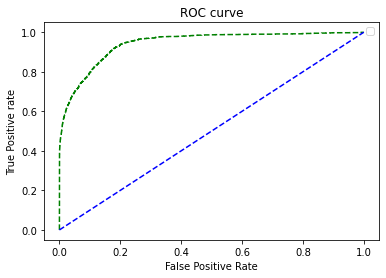

In [51]:
plt.plot(fpr_log2, tpr_log2, linestyle='--',color='green')
plt.plot(p_fpr_log, p_tpr_log, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [52]:
from sklearn.metrics import recall_score, precision_score
print(f"recall_score:  {recall_score(y_test, y_test_pred)}")
print(f"precision_score:  {precision_score(y_test, y_test_pred)}")
print(f"F1 score:  {f1_score(y_test, y_test_pred, average='weighted')}")

recall_score:  0.42567567567567566
precision_score:  0.4688768606224628
F1 score:  0.9968210196654043


Text(0.5, 1.0, 'Logistic-Reg Precision / Recall plot')

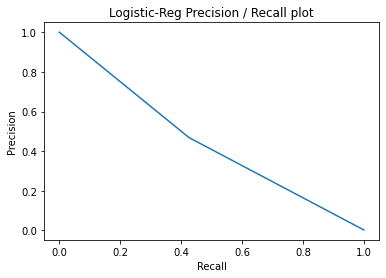

In [84]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_test_pred)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Logistic-Reg Precision / Recall plot')

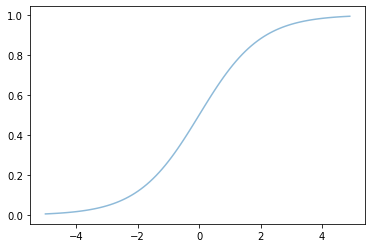

In [53]:
h = lambda z: 1. / (1 + np.exp(-z))
zs=np.arange(-5, 5, 0.1)
plt.plot(zs, h(zs), alpha=0.5);

In [54]:
# classification_report
print(classification_report(y_test, XgB_test_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552454
           1       1.00      0.99      1.00      1628

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082



  
  **<font color='Red'> Logistic Regression Observation: </font>**
  
 **<font color='blue'> - Used the C value in the procedure and train a Logistic Regression on the training data

 - <font color='blue'>  Here it is clear that the precision score gives us  46.88%. ROC curve - 94.28% and F1 score gives us 99.68%
  
  
 - <font color='blue'> Here we found type I error(False Positive) with 935 fraud values which predicted not fraud. So we found the precision score. 


 - <font color='blue'>  Accuracy Score is not a good metric for imbalanced data. So, here we performed regularization parameter C, F-Beta store, ROC-AUC score, and precision score to get  better performance.


 


### Case 4:  Decision Tree

In [55]:

from sklearn.tree import DecisionTreeClassifier
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}


# Instantiate the grid search model
DT = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator = DT, 
                           param_grid = param_grid, 
                           scoring= 'roc_auc',
                           cv = 3, 
                           verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  24 out of  24 | elapsed:  6.5min finished


GridSearchCV(cv=3, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50)},
             scoring='roc_auc', verbose=1)

In [56]:
#Printing the optimal sensitivity score and hyperparameters

print("Best roc_auc:-", grid_search.best_score_)
print(grid_search.best_estimator_)

Best roc_auc:- 0.9990116554883602
DecisionTreeClassifier(max_depth=10, min_samples_leaf=100,
                       min_samples_split=100)


####  Decision Tree  prediction with Gini model

In [57]:
from sklearn import tree, metrics
gini_model = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=5, 
                                  min_samples_leaf=50,
                                  min_samples_split=50)

gini_model.fit(X_train, y_train)
gini_pred = gini_model.predict(X_test)
gini_pred = pd.Series(gini_pred)
gini_model

DecisionTreeClassifier(max_depth=5, min_samples_leaf=50, min_samples_split=50,
                       random_state=100)

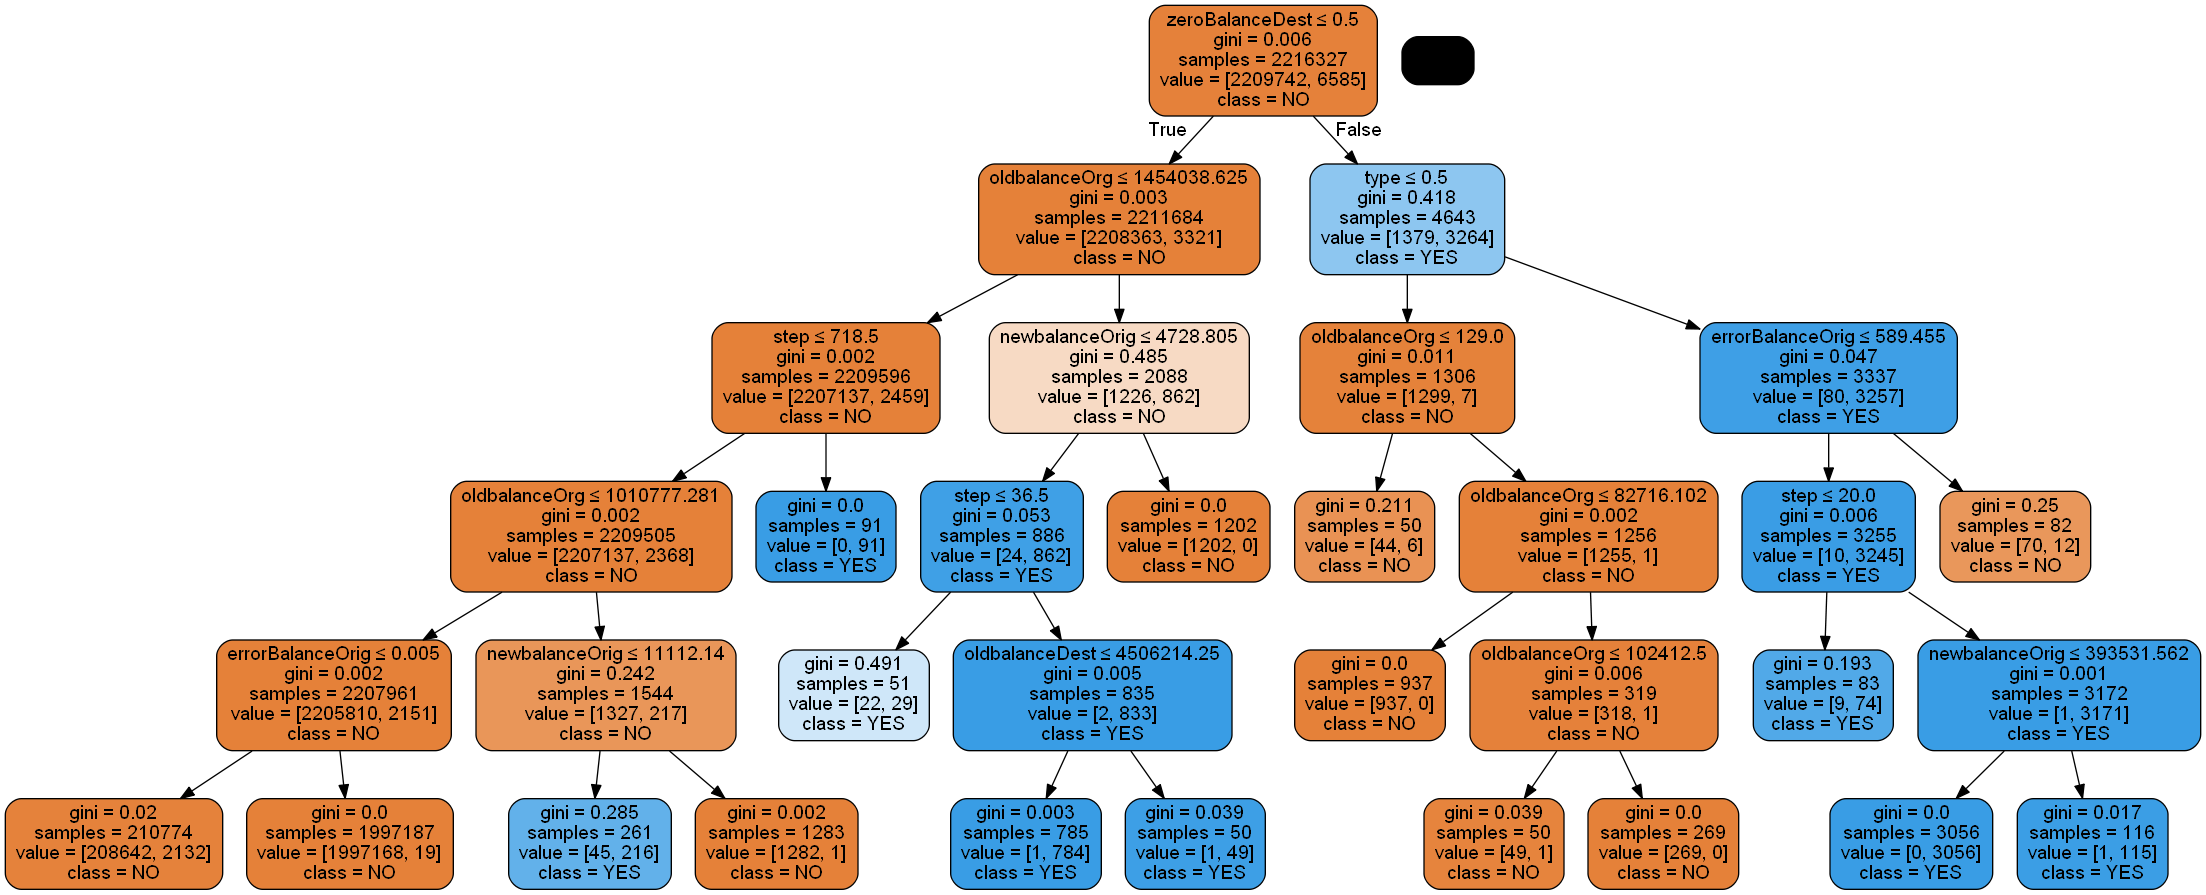

In [58]:
from io import StringIO 
from IPython.display import Image  
import pydotplus
dot_data = StringIO()
tree.export_graphviz(gini_model, out_file=dot_data,
                    filled=True, rounded=True,
                    special_characters=True, feature_names=X_train.columns, class_names = ["NO", "YES"])


# Alternatively for class_names use entr_model.classes_
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [59]:
from sklearn.metrics import confusion_matrix
TP, FP, FN, TN = confusion_matrix(y_test, gini_pred).ravel()
c_matrix = pd.DataFrame({'Predicted = Fraud': [TP, FP],
                                 'Predicted = Not Fraud': [FN, TN]
                                }, index=['Fraud', 'Not Fraud'])
c_matrix

,Predicted = Fraud,Predicted = Not Fraud
Fraud,552440,541
Not Fraud,14,1087


Here we have to reduce the type I error(False Positive) as 541 fraud values are predicted not fraud. So we have to find the precision score.

Accuracy Score is not a good metric for imbalanced data. So, hyperparameter tuning, F-Beta store or Roc-AUC score will be a better value.

####  Calculate the ROC for the model as well

In [60]:
# roc curve for models

gini_pred_prob = gini_model.predict_proba(X_test)

fpr_gini1, tpr_gini1, gini_thresh1 = roc_curve(y_test, gini_pred_prob[:,1], pos_label=1)
fpr_gini2, tpr_gini2, gini_thresh2 = roc_curve(y_test, gini_pred_prob[:,1], pos_label=1)

# roc curve for tpr = fpr 
gini_probs = [0 for i in range(len(y_test))]
p_fpr_gini, p_tpr_gini, _ = roc_curve(y_test, gini_probs, pos_label=1)

In [61]:
# auc scores
auc_score1 = roc_auc_score(y_test, gini_pred_prob[:,1])
auc_score2 = roc_auc_score(y_test, gini_pred_prob[:,1])

print(auc_score1, auc_score2)

0.9807224775088615 0.9807224775088615


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


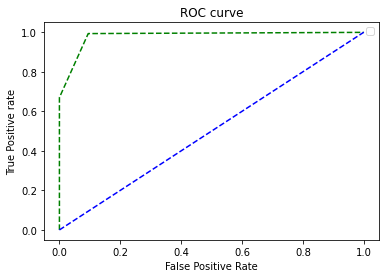

In [62]:
plt.plot(fpr_gini2, tpr_gini2, linestyle='--',color='green')
plt.plot(p_fpr_gini, p_tpr_gini, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [63]:
from sklearn.metrics import recall_score, precision_score
print(f"recall_score:  {recall_score(y_test, gini_pred)}")
print(f"precision_score:  {precision_score(y_test, gini_pred)}")
print(f"F1 score:  {f1_score(y_test, gini_pred, average='weighted')}")

recall_score:  0.6676904176904177
precision_score:  0.9872842870118075
F1 score:  0.9989018664806611


Text(0.5, 1.0, 'Gini_model Precision / Recall plot')

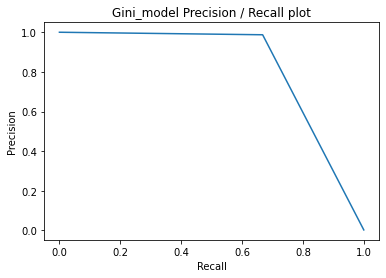

In [85]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, gini_pred)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Gini_model Precision / Recall plot')

In [64]:
# classification_report
print(classification_report(y_test, gini_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552454
           1       0.99      0.67      0.80      1628

    accuracy                           1.00    554082
   macro avg       0.99      0.83      0.90    554082
weighted avg       1.00      1.00      1.00    554082




  **<font color='Red'> Decision Tree Gini model Observation: </font>**
    
  
  - <font color='blue'>  Here it is clear that the precision score gives us  98.72%. ROC curve - 98.07% and F1 score gives us 99.89%
  
  
 - <font color='blue'> Here we found type I error(False Positive) with 541 fraud values which predicted not fraud. So we found the precision score. 


 - <font color='blue'>  Accuracy Score is not a good metric for imbalanced data. So, here we performed Gini model tuning, F-Beta store, ROC-AUC score, and precision score to get  better performance.


#### Decision Tree Entropy model

In [65]:
from sklearn import tree, metrics
entropy_model = DecisionTreeClassifier(criterion = "entropy", 
                                  random_state = 100,
                                  max_depth=5, 
                                  min_samples_leaf=50,
                                  min_samples_split=50)

entropy_model.fit(X_train, y_train)
entropy_pred = entropy_model.predict(X_test)
entropy_pred = pd.Series(entropy_pred)
entropy_model

DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_leaf=50,
                       min_samples_split=50, random_state=100)

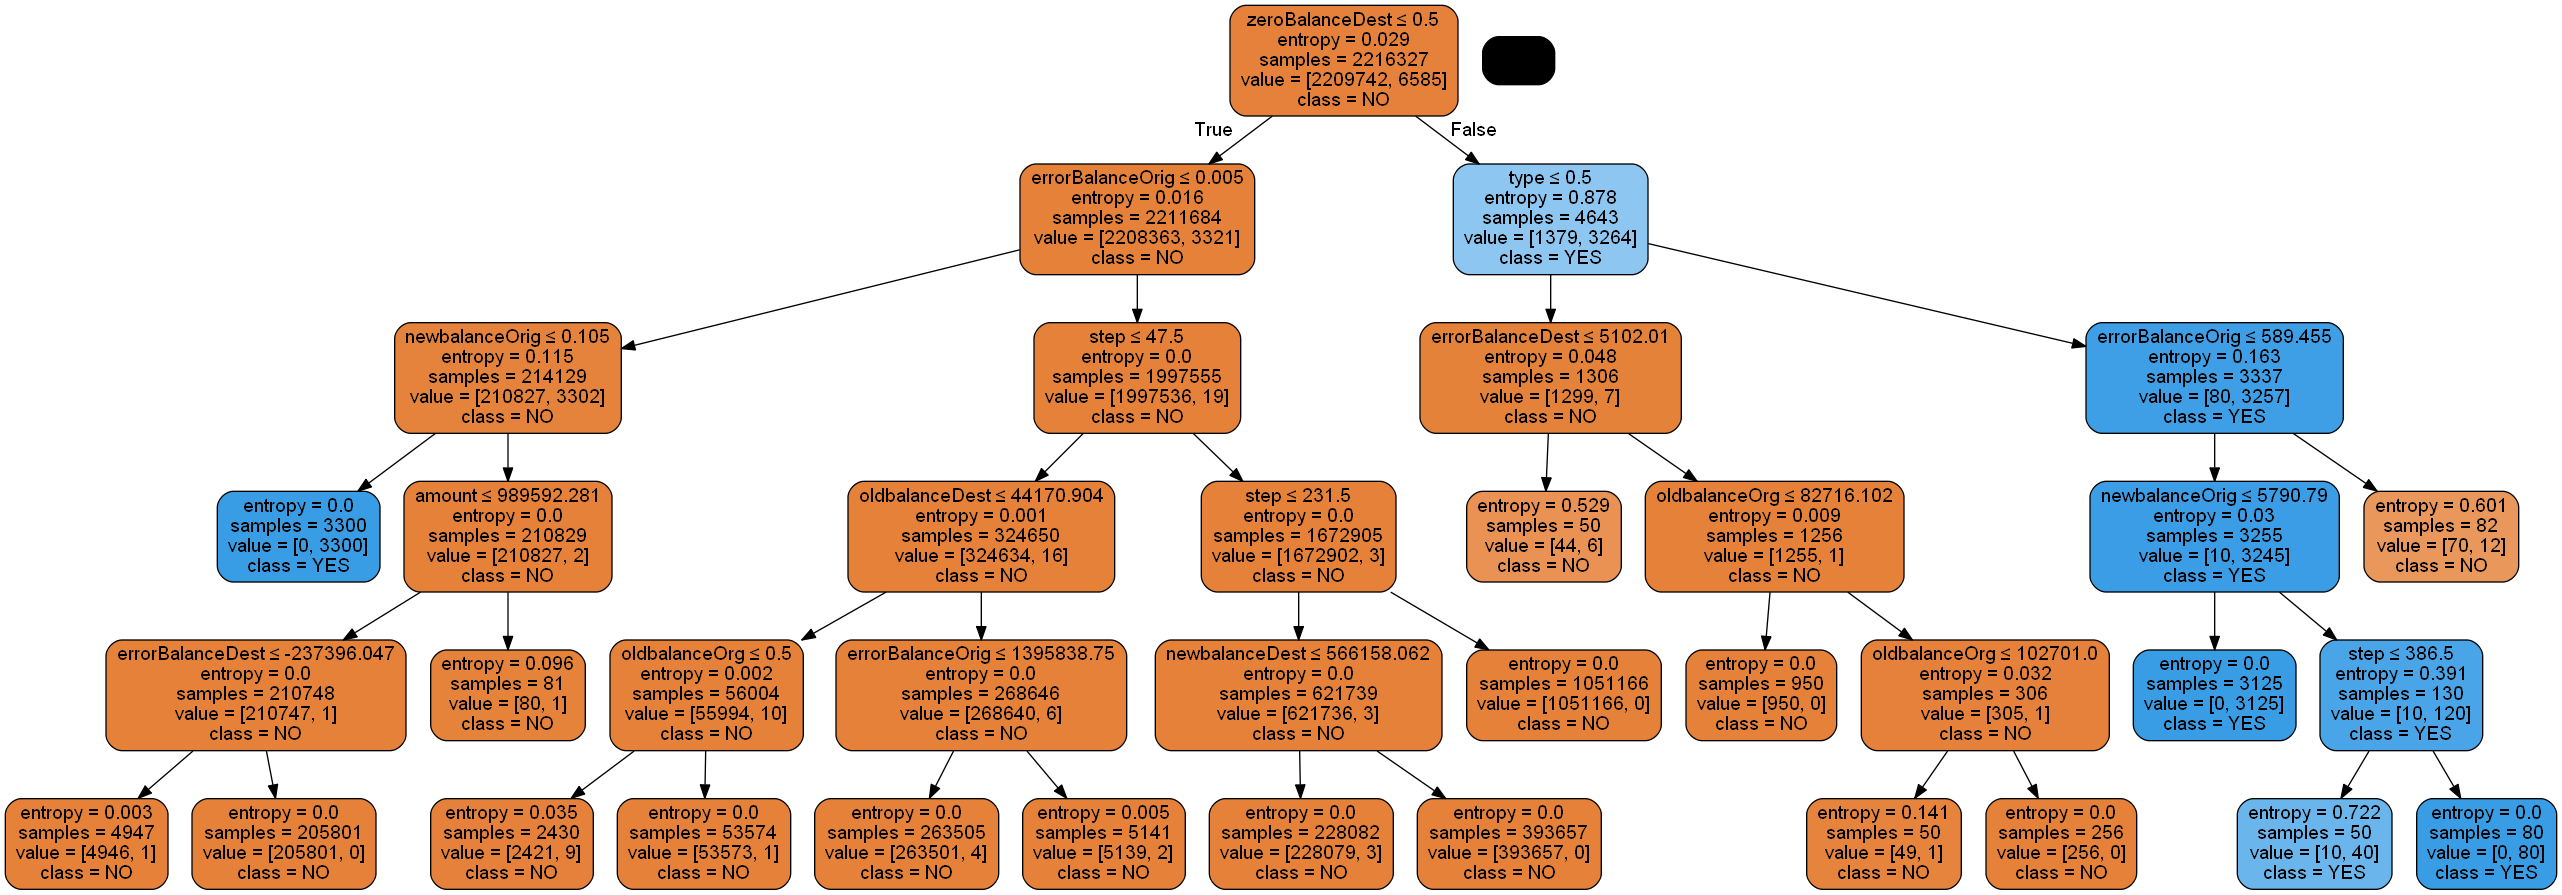

In [66]:
from io import StringIO 
from IPython.display import Image  
import pydotplus
dot_data = StringIO()
tree.export_graphviz(entropy_model, out_file=dot_data,
                    filled=True, rounded=True,
                    special_characters=True, feature_names=X_train.columns, class_names = ["NO", "YES"])


# Alternatively for class_names use entr_model.classes_
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [67]:
from sklearn.metrics import confusion_matrix
TP, FP, FN, TN = confusion_matrix(y_test, entropy_pred).ravel()
c_matrix = pd.DataFrame({'Predicted = Fraud': [TP, FP],
                                 'Predicted = Not Fraud': [FN, TN]
                                }, index=['Fraud', 'Not Fraud'])
c_matrix

,Predicted = Fraud,Predicted = Not Fraud
Fraud,552450,15
Not Fraud,4,1613


 Here we have to reduce the type I error(False Positive) as 15 fraud values are predicted not fraud. So we have to find the precision score.

Accuracy Score is not a good metric for imbalanced data. So, entropy model, F-Beta store or ROC-AUC score will be a better value.

#### Calculate the ROC for the model as well

In [68]:
# roc curve for models

entropy_pred_prob = entropy_model.predict_proba(X_test)

fpr_entropy1, tpr_entropy1, entropy_thresh1 = roc_curve(y_test, entropy_pred_prob[:,1], pos_label=1)
fpr_entropy2, tpr_entropy2, entropy_thresh2 = roc_curve(y_test, entropy_pred_prob[:,1], pos_label=1)

# roc curve for tpr = fpr 
entropy_probs = [0 for i in range(len(y_test))]
p_fpr_entropy, p_tpr_entropy, _ = roc_curve(y_test, entropy_probs, pos_label=1)

In [69]:
# auc scores
auc_score1 = roc_auc_score(y_test, entropy_pred_prob[:,1])
auc_score2 = roc_auc_score(y_test, entropy_pred_prob[:,1])

print(auc_score1, auc_score2)

0.9988864137834006 0.9988864137834006


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


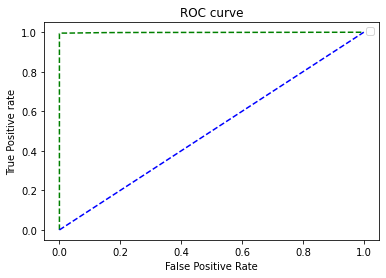

In [70]:
plt.plot(fpr_entropy2, tpr_entropy2, linestyle='--',color='green')
plt.plot(p_fpr_entropy, p_tpr_entropy, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

In [79]:
from sklearn.metrics import recall_score, precision_score
print(f"recall_score:  {recall_score(y_test, entropy_pred)}")
print(f"precision_score:  {precision_score(y_test, entropy_pred)}")
print(f"F1 score:  {f1_score(y_test, entropy_pred, average='weighted')}")

recall_score:  0.9907862407862408
precision_score:  0.9975262832405689
F1 score:  0.9999656510971071


Text(0.5, 1.0, 'entropy Precision / Recall plot')

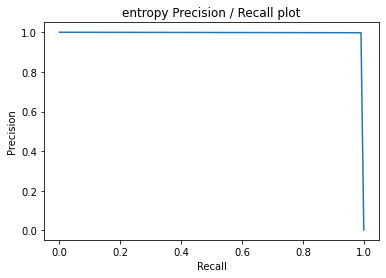

In [86]:
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, entropy_pred)

plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('entropy Precision / Recall plot')

In [87]:
# classification_report
print(classification_report(y_test, entropy_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    552454
           1       1.00      0.99      0.99      1628

    accuracy                           1.00    554082
   macro avg       1.00      1.00      1.00    554082
weighted avg       1.00      1.00      1.00    554082



   **<font color='Red'> Decision Tree Entropy model Observation: </font>**
    
  
  - <font color='blue'>  Here it is clear that the precision score gives us  99.75%. ROC curve - 99.88% and F1 score gives us 99.99%
  
  
 - <font color='blue'> Here we found type I error(False Positive) with 15 fraud values which predicted not fraud. So we found the precision score. 


 - <font color='blue'>  Accuracy Score is not a good metric for imbalanced data. So, here we performed Entropy model tuning, F-Beta store, ROC-AUC score, and precision score to get  better performance.


### Summary:
    
- XgBoost,  Decision Tree Entropy model, and Random Forest are performing well and gives us the best estimation.
   - The best model is XgBoost classification Algorithm with 99.99% performance.
   

- We have performed the  hyperparameter tuning techniques to handle the quantitative variables in a better manner.

- performed model tuning and selected the regularization parameter 'C' in Logistic Regression classification algorithm.

- Performed Gini model and Entropy model.



##### ROC-AUC score model comparison

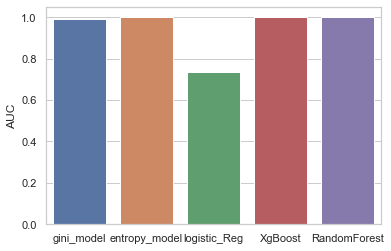

In [88]:
sns.set_theme(style="whitegrid")
sns.barplot(x=["gini_model", "entropy_model", "logistic_Reg", "XgBoost", "RandomForest"],
            y=[roc_auc_score(gini_model.predict(X_test), y_test), roc_auc_score(entropy_model.predict(X_test), y_test), roc_auc_score(logreg_model.predict(X_test), y_test),
               roc_auc_score(XgB_df_model.predict(X_test), y_test), roc_auc_score(rf_classifier.predict(X_test), y_test)])
               
plt.ylabel("AUC") 
plt.show()

In ROC-AUC score XgBoost performs very well. Also, Random Forest and Entropy model performing with a good score. A small variation in the score makes huge loss to the bank. But in imbalanced data we choose F1 Score and precision score.

##### precision_score model comparison

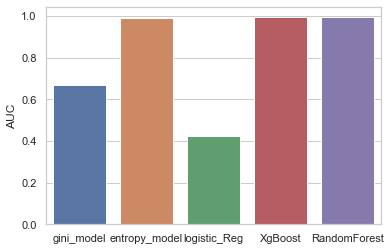

In [89]:
sns.set_theme(style="whitegrid")
sns.barplot(x=["gini_model", "entropy_model", "logistic_Reg", "XgBoost", "RandomForest"],
            y=[precision_score(gini_model.predict(X_test), y_test), precision_score(entropy_model.predict(X_test), y_test), precision_score(logreg_model.predict(X_test), y_test),
               precision_score(XgB_df_model.predict(X_test), y_test), precision_score(rf_classifier.predict(X_test), y_test)])
               
plt.ylabel("AUC") 
plt.show()

In Precision Score  XgBoost performs very well. Also, Random Forest and Entropy model performing  with a good score. 

#### f1_score model comparison

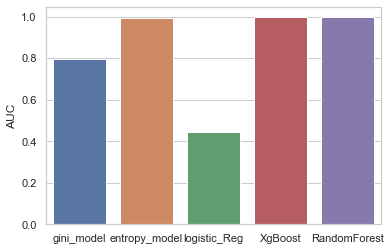

In [90]:
sns.set_theme(style="whitegrid")
sns.barplot(x=["gini_model", "entropy_model", "logistic_Reg", "XgBoost", "RandomForest"],
            y=[f1_score(gini_model.predict(X_test), y_test), f1_score(entropy_model.predict(X_test), y_test), f1_score(logreg_model.predict(X_test), y_test),
               f1_score(XgB_df_model.predict(X_test), y_test), f1_score(rf_classifier.predict(X_test), y_test)])
               
plt.ylabel("AUC") 
plt.show()

### Model Comparisons

![](img9.png "Title")

In our imbalanced class data set f1_score is a very good score to measure the fraud. 

Here XgBoost and Random Forest and Entropy works very well.

In [97]:
# Save the data 
from library.sb_utils import save_file

datapath = '.'

save_file(df, 'modeling.csv', datapath)

A file already exists with this name.

Do you want to overwrite? (Y/N)y
Writing file.  ".\modeling.csv"
